**Sarcasm Detection using NLP**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/Sarcasm_Headlines_Dataset_v2.csv')

In [3]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
df.shape

(28619, 2)

In [5]:
df.isnull().sum()

,0
is_sarcastic,0
headline,0


In [6]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
lem = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

In [8]:
def clean_text(news):
    """
    This function receives headlines sentence and returns clean sentence
    """
    news = news.lower()
    news = re.sub("\\n", "", news)

    #Split the sentences into words
    words = list(news.split())

    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]

    clean_sen = " ".join(words)

    return clean_sen

In [9]:
df['headline_len'] = df.headline.apply(lambda x: len(x.split()))

In [10]:
df['news_headline'] = df.headline.apply(lambda news: clean_text(news))
df.head()

,is_sarcastic,headline,headline_len,news_headline
0,1,thirtysomething scientists unveil doomsday clo...,8,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,13,dem rep. totally nail why congress be fall sho...
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,8,inclement weather prevent liar from get to work
4,1,mother comes pretty close to using word 'strea...,9,mother come pretty close to use word 'streamin...


In [11]:
df.groupby(['is_sarcastic']).headline_len.mean()

,headline_len
is_sarcastic,
0,9.815616
1,10.307540


In [12]:
df.groupby(['is_sarcastic']).headline_len.max()

,headline_len
is_sarcastic,
0,38
1,151


In [13]:
X = df['news_headline']
y = df['is_sarcastic']

In [14]:
X.head()

,news_headline
0,thirtysomething scientists unveil doomsday clo...
1,dem rep. totally nail why congress be fall sho...
2,eat your veggies: 9 deliciously different recipes
3,inclement weather prevent liar from get to work
4,mother come pretty close to use word 'streamin...


In [15]:
y.head()

,is_sarcastic
0,1
1,0
2,0
3,1
4,1


**WORDVEC**

In [16]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'of',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'why',
  'congress',
  'is',
  'falling',
  'short',
  'on',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'your', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'from', 'getting', 'to', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'to',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [17]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [18]:
#vocab size
len(w2v_model.wv)
#We have now represented each of 38071 words by a 100dim vector.

38234

In [19]:
from tensorflow.keras.preprocessing import text, sequence

In [20]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [21]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [22]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        model.wv.get_vector(word)
    return weight_matrix

In [23]:
import numpy as np

In [24]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

**Training**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

In [27]:
y_train.value_counts()

,count
is_sarcastic,
0,11988
1,10907


In [28]:
max_words = 38235    # how many unique words to use (i.e num rows in embedding vector)
max_len = 20       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 200    # how big is each word vector

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [30]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_words,  # Match vocab size
    output_dim=embed_size,  # Match embedding dimension
    weights=[embedding_vectors],  # Ensure this matches shape (max_words, embed_size)
    trainable=False  # Set False if using static embeddings
)

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [ ]:
train_sequences

**RNN MODEL**

In [50]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
history_rnn = model_rnn.fit(X_train, y_train, batch_size=32, epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 55s 72ms/step - accuracy: 0.5882 - loss: 0.6382 - val_accuracy: 0.8384 - val_loss: 0.3685 - learning_rate: 0.0010
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.8919 - loss: 0.2815 - val_accuracy: 0.8615 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.9534 - loss: 0.1416 - val_accuracy: 0.8534 - val_loss: 0.3928 - learning_rate: 0.0010
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.9772 - loss: 0.0780 - val_accuracy: 0.8470 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.9904 - loss: 0.0375 - val_accuracy: 0.8510 - val_loss: 0.5374 - learning_rate: 1.0000e-04


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8434 - loss: 0.5582
Test Loss: 0.5374098420143127
Test Accuracy: 0.8509783148765564
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


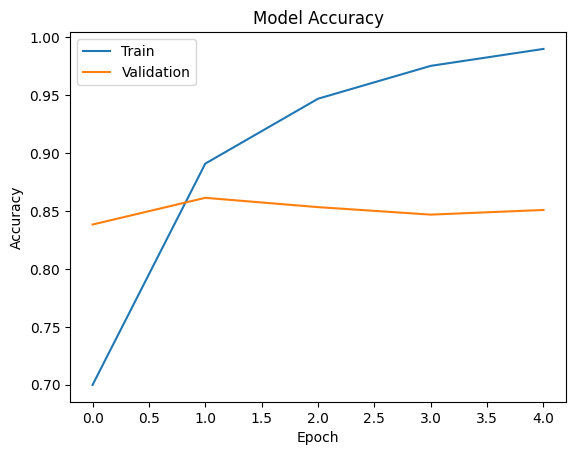

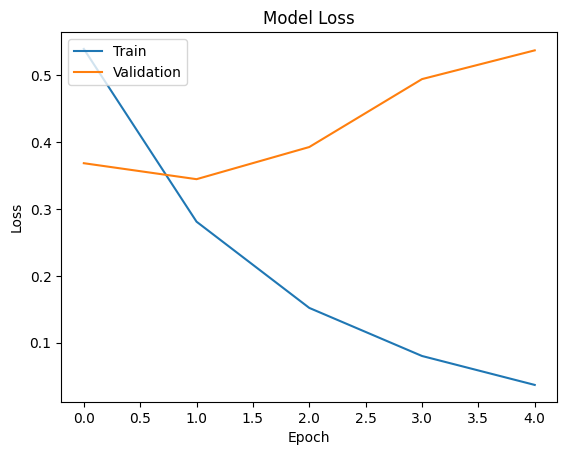

In [54]:
# Evaluate the model
score = model_rnn.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# List all data in history
print(history_rnn.history.keys())

# Summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# Predictions and evaluation
y_pred = model_rnn.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold for binary classification (adjust as needed)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Classification report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.851132718054818
Recall: 0.8509783368273934
F1 Score: 0.8508199802361157

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.85      0.87      0.86      2997
     Class 1       0.86      0.83      0.84      2727

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



**LSTM**

In [39]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size=32, epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.7127 - loss: 0.5256 - val_accuracy: 0.8588 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 55s 77ms/step - accuracy: 0.9297 - loss: 0.1910 - val_accuracy: 0.8660 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.9721 - loss: 0.0848 - val_accuracy: 0.8662 - val_loss: 0.3917 - learning_rate: 0.0010
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.9913 - loss: 0.0341 - val_accuracy: 0.8648 - val_loss: 0.4663 - learning_rate: 1.0000e-04
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.9920 - loss: 0.0281 - val_accuracy: 0.8625 - val_loss: 0.5133 - learning_rate: 1.0000e-04


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8618 - loss: 0.5368
Test Loss: 0.5132535696029663
Test Accuracy: 0.8625087141990662
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


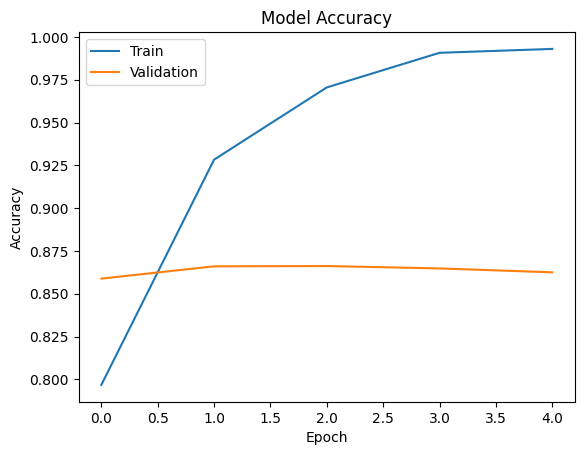

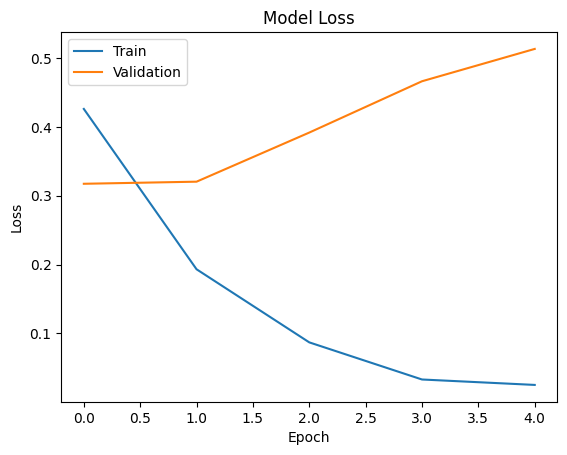

In [42]:
# Evaluate the model
score = model_lstm.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# List all data in history
print(history_lstm.history.keys())

# Summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
# Predictions and evaluation
y_pred = model_lstm.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold for binary classification (adjust as needed)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Classification report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Precision: 0.8625023203945363
Recall: 0.8625087351502446
F1 Score: 0.8625052904710802

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.87      0.87      2997
     Class 1       0.86      0.86      0.86      2727

    accuracy                           0.86      5724
   macro avg       0.86      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724



**BIDIRECTIONAL LSTM**

In [56]:
model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [57]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
history_bidir = model_bidir.fit(X_train, y_train, batch_size=32, epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 67s 88ms/step - accuracy: 0.7346 - loss: 0.4967 - val_accuracy: 0.8650 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.9513 - loss: 0.1359 - val_accuracy: 0.8655 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.9876 - loss: 0.0406 - val_accuracy: 0.8615 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - accuracy: 0.9961 - loss: 0.0142 - val_accuracy: 0.8641 - val_loss: 0.5521 - learning_rate: 1.0000e-04
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.8630 - val_loss: 0.6140 - learning_rate: 1.0000e-04


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8626 - loss: 0.6416
Test Loss: 0.6140488386154175
Test Accuracy: 0.8630328178405762
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


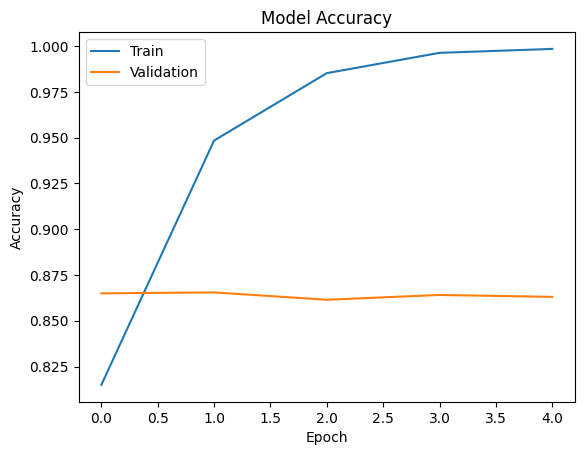

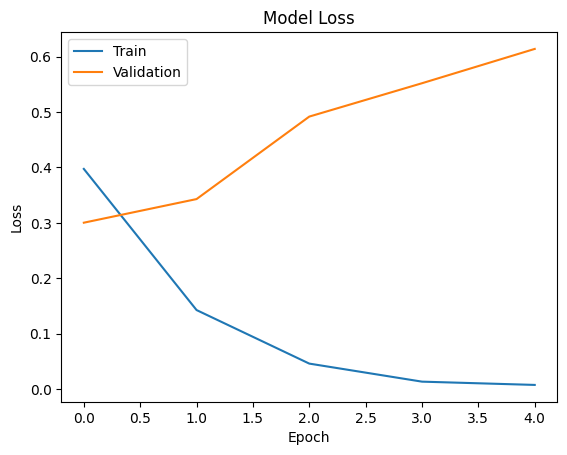

In [59]:
# Evaluate the model
score = model_bidir.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# List all data in history
print(history_bidir.history.keys())

# Summarize history for accuracy
plt.plot(history_bidir.history['accuracy'])
plt.plot(history_bidir.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history_bidir.history['loss'])
plt.plot(history_bidir.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [60]:
# Predictions and evaluation
y_pred = model_bidir.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold for binary classification (adjust as needed)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Classification report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))

179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Precision: 0.8630732069457152
Recall: 0.8630328441649197
F1 Score: 0.8630478567246626

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.87      0.87      2997
     Class 1       0.85      0.86      0.86      2727

    accuracy                           0.86      5724
   macro avg       0.86      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724

